In [1]:
pip install matminer scikit-learn pymatgen xgboost


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.6/55.6 kB 4.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 75.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.1/5.1 MB 83.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.9/51.9 kB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 332.3/332.3 kB 24.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 61.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 118.6/118.6 kB 9.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 809.0/809.0 kB 47.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.1/60.1 kB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 313.6/313.6 kB 22.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 739.1/739.1 kB 46.2 MB/s eta 0:00:00
  Created wheel for bibtexparser: filename=bibtexparser-1.4.3-py3-none-any.whl size=4354

In [7]:
# bulk_modulus_regression.ipynb

# 1. Import libraries
import pandas as pd
import numpy as np
from matminer.featurizers.composition import ElementProperty
from pymatgen.core import Composition
from sklearn.linear_model import Ridge
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns

In [17]:
# 2. Load and clean data
df = pd.read_csv("/content/elastic_properties_dataset.csv")
import ast
def extract_vrh(entry):
    try:
        parsed = ast.literal_eval(entry)
        return parsed.get('vrh', None)
    except:
        return None

df['bulk_vrh'] = df['bulk_modulus'].apply(extract_vrh)
df = df.dropna(subset=['bulk_vrh', 'formula'])
df['bulk_vrh'] = df['bulk_vrh'].astype(float)
df = df[(df['bulk_vrh'] > 0) & (df['bulk_vrh'] < 500)]


/tmp/ipython-input-17-3652703978.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['bulk_vrh'] = df['bulk_vrh'].astype(float)


In [18]:
# 3. Featurize chemical formulas
featurizer = ElementProperty.from_preset("magpie")
df['composition'] = df['formula'].apply(lambda x: Composition(x) if isinstance(x, str) else None)
df = df.dropna(subset=['composition'])

features = featurizer.featurize_dataframe(df, "composition", ignore_errors=True)
features = features.replace([np.inf, -np.inf], np.nan).dropna(axis=1)


/usr/local/lib/python3.11/dist-packages/matminer/utils/data.py:326: UserWarning: MagpieData(impute_nan=False):
In a future release, impute_nan will be set to True by default.
                    This means that features that are missing or are NaNs for elements
                    from the data source will be replaced by the average of that value
                    over the available elements.
                    This avoids NaNs after featurization that are often replaced by
                    dataset-dependent averages.
  warnings.warn(f"{self.__class__.__name__}(impute_nan=False):\n" + IMPUTE_NAN_WARNING)


ElementProperty:   0%|          | 0/12880 [00:00<?, ?it/s]

In [19]:

X = features.loc[:, features.columns.intersection(featurizer.feature_labels())]
y = features['bulk_vrh'].astype(float)

In [20]:
# 4. Train/Validation/Test Split
X_trainval, X_test, y_trainval, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_trainval, y_trainval, test_size=0.25, random_state=42)

# 5. Train Regression Model (Ridge)
model = Ridge(alpha=1.0)
model.fit(X_train, y_train)

# 6. Evaluate on validation and test
val_preds = model.predict(X_val)
test_preds = model.predict(X_test)

print("Validation R^2:", r2_score(y_val, val_preds))
print("Test R^2:", r2_score(y_test, test_preds))
print("Test MAE:", mean_absolute_error(y_test, test_preds))
print("Test RMSE:", mean_squared_error(y_test, test_preds))

Validation R^2: 0.6244169105038566
Test R^2: 0.6519406713594625
Test MAE: 31.847382073568006
Test RMSE: 1901.6610069706117


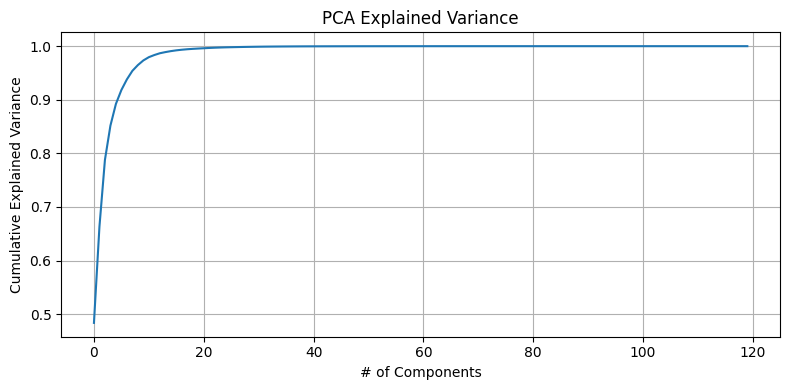

In [21]:
# 7. PCA Analysis
pca = PCA()
pca.fit(X)
explained = np.cumsum(pca.explained_variance_ratio_)
plt.figure(figsize=(8,4))
plt.plot(explained)
plt.xlabel("# of Components")
plt.ylabel("Cumulative Explained Variance")
plt.title("PCA Explained Variance")
plt.grid(True)
plt.tight_layout()
plt.show()

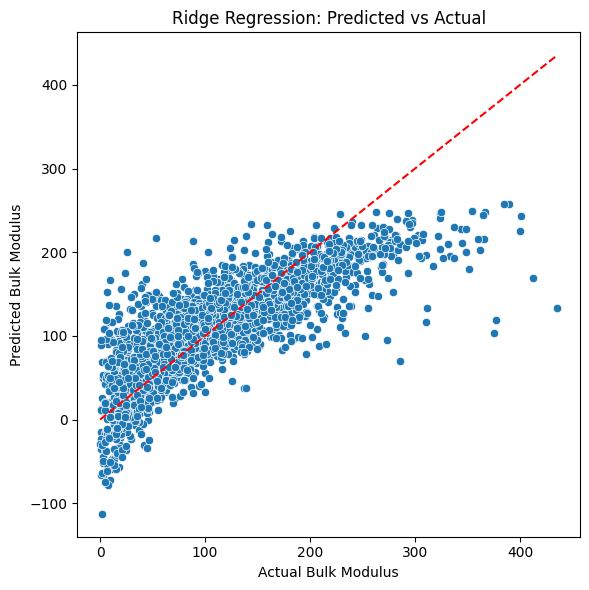

In [22]:
# 8. Predicted vs Actual Plot
plt.figure(figsize=(6,6))
sns.scatterplot(x=y_test, y=test_preds)
plt.xlabel("Actual Bulk Modulus")
plt.ylabel("Predicted Bulk Modulus")
plt.title("Ridge Regression: Predicted vs Actual")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.tight_layout()
plt.show()
